In [1]:
import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt

In [2]:
class PriorMean(gpytorch.means.Mean):
    def __init__(self):
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.tensor([0.5]))
        self.beta = torch.nn.Parameter(torch.tensor([1.0]))
        self.softplus = torch.nn.Softplus()

    def forward(self, x):
        alpha = self.softplus(self.alpha)
        beta = torch.sigmoid(self.beta)
        return 1.0 - (0.05 + alpha * torch.pow(torch.pow(10, x), -beta)).ravel()
    
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, n_list, metric_list, likelihood):
        super(GPModel, self).__init__(n_list, metric_list, likelihood)
        self.mean_module = PriorMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(torch.log10(x))
        covar_x = self.covar_module(torch.log10(x))
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
n_list = torch.tensor([210, 315, 473])
metric_list = torch.tensor([62.04, 68.98,  69.75]) / 100.
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(n_list, metric_list, likelihood)
model.covar_module.outputscale = 0.0009
model.covar_module.base_kernel.lengthscale = 2.0

In [3]:
training_iter = 100

model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):

    optimizer.zero_grad()

    output = model(n_list)

    loss = -mll(output, metric_list)
    loss.backward()
    print('Iter {}/{} - Loss: {:.3f}   lengthscale: {:.3f}   noise: {:.3f}'.format(
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.788   lengthscale: 2.000   noise: 0.693
Iter 2/100 - Loss: 0.754   lengthscale: 2.086   noise: 0.644
Iter 3/100 - Loss: 0.719   lengthscale: 2.173   noise: 0.598
Iter 4/100 - Loss: 0.684   lengthscale: 2.260   noise: 0.554
Iter 5/100 - Loss: 0.647   lengthscale: 2.348   noise: 0.513
Iter 6/100 - Loss: 0.609   lengthscale: 2.435   noise: 0.474
Iter 7/100 - Loss: 0.570   lengthscale: 2.522   noise: 0.437
Iter 8/100 - Loss: 0.529   lengthscale: 2.608   noise: 0.403
Iter 9/100 - Loss: 0.486   lengthscale: 2.694   noise: 0.370
Iter 10/100 - Loss: 0.441   lengthscale: 2.778   noise: 0.340
Iter 11/100 - Loss: 0.393   lengthscale: 2.860   noise: 0.312
Iter 12/100 - Loss: 0.341   lengthscale: 2.940   noise: 0.286
Iter 13/100 - Loss: 0.287   lengthscale: 3.017   noise: 0.262
Iter 14/100 - Loss: 0.230   lengthscale: 3.090   noise: 0.239
Iter 15/100 - Loss: 0.171   lengthscale: 3.159   noise: 0.218
Iter 16/100 - Loss: 0.114   lengthscale: 3.223   noise: 0.198
Iter 17/100 - Los

In [4]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(100, 20000, 1000).long()
    observed_pred = likelihood(model(test_x))

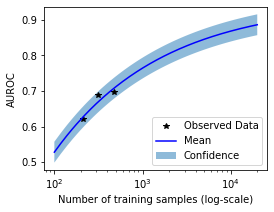

In [5]:
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    lower, upper = observed_pred.confidence_region()
    ax.plot(n_list.numpy(), metric_list.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_xscale('log')
    ax.set_xlabel('Number of training samples (log-scale)')
    ax.set_ylabel('AUROC')
    plt.show()